# Project: Evaluating Deep-Learning Models for Detecting Orientation and Flipping of X-Ray Scans
## Objective: Develop a Reliable Method to Detect Orientation and Flipping of PA and Lateral Ceph Scans in the BB-Collection
---
### Background

In the BB-Collection, we identified several TIFF scans with inconsistent rotation and flipping. Specifically, Lateral Cephs and PAs should be oriented to the right and upwards, respectively.

### Strategy

Based on the findings in the work of Swami et al. [[1]](#References), we've determined that deep learning (DL) is the most appropriate method to accomplish this task.  
Specifically, we will make use of pre-trained models through *transfer learning*. This is the process of fine-tuning a model that has already been trained on millions of images to recognize more than 1000 classes of objects.  

We will evaluate various models with different architectures and sizes (number of neurons and layers), and assess their performance specifically within the context of the BB-Collection.  

### Preparing the trainig-set
We will use a subset of the BB-Collection scans, specifically the *Laterals* that are available on the AAOF website which are already correctly oriented (patient looking to the right).  
For each file we need to generate all possible combinations of rotation (in 90 degrees steps) and flip. We will use this augmented dataset to train and evaluate the DL models.

In [1]:
# Usual imports

from fastai.vision.all import *
import numpy as np
from PIL import Image
from pathlib import Path
import re

In [2]:
# Augment the dataset:
# For each file generate all possible combinations of rotation and flip

path = Path("BB_AAOF_WEB/Laterals")
train_folder = "Train"
scans = list(path.glob("*.jpg"))
len(scans)

1066

In [ ]:
rotations = [90, 180, 270]

for scan in scans:
    img = Image.open(scan)
    img.save(f"{train_folder}/{scan.stem}_0.png")
    img_flip = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
    img_flip.save(f"{train_folder}/{scan.stem}_0F.png")
    for rot in rotations:
        # img_rot = img.rotate(rot)
        img_rot = img.transpose(Image.Transpose[f"ROTATE_{rot}"])
        img_rot.save(f"{train_folder}/{scan.stem}_{rot}.png")
        img_rot_flip = img_rot.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
        img_rot_flip.save(f"{train_folder}/{scan.stem}_{rot}F.png")

In [3]:
# Setting up FastAI dataloader and model for fine-tuning

files = get_image_files("Train")
len(files)

8528

In [4]:
# This function generates labels from filenames

def label_func(f):
    match = re.search(r'_(.*?)\.png', f)
    return match.group(1)

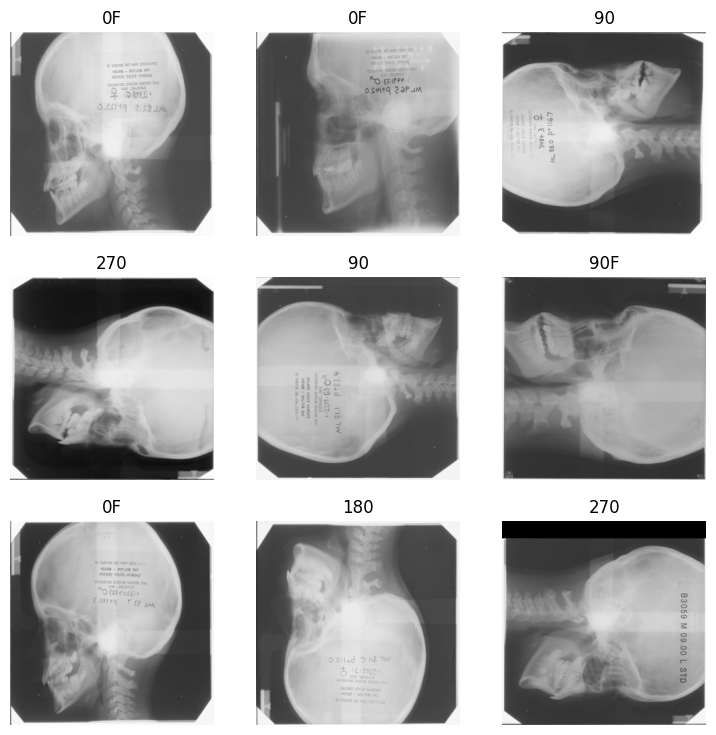

In [5]:
dls = ImageDataLoaders.from_name_func(train_folder, files, label_func, item_tfms=Resize(size=299, method=ResizeMethod.Squish), seed=42)
dls.show_batch()

/home/frenchfaso/miniconda3/envs/fastai/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/frenchfaso/miniconda3/envs/fastai/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


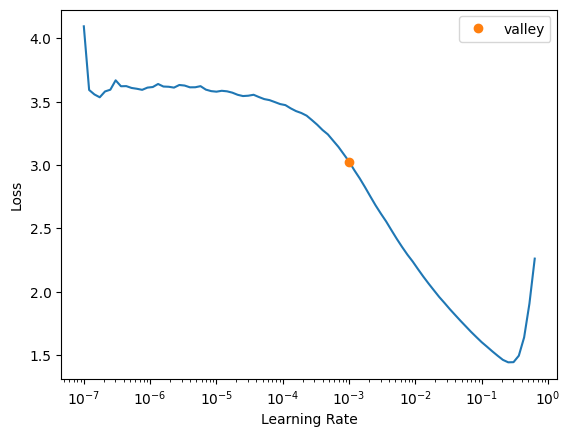

In [6]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.to_fp16()
lr = learn.lr_find()

In [7]:
learn.fine_tune(15, lr.valley * 10)

epoch,train_loss,valid_loss,accuracy,time
0,0.230699,0.068449,0.981818,00:17


epoch,train_loss,valid_loss,accuracy,time
0,0.019979,0.011655,0.997654,00:21
1,0.012289,0.008467,0.997654,00:21
2,0.018429,0.031066,0.993548,00:20
3,0.006705,0.000059,1.000000,00:20
4,0.001417,0.000043,1.000000,00:21
5,0.019852,0.008223,0.998240,00:21
6,0.006833,0.004797,0.999413,00:21
7,0.001995,0.003727,0.999413,00:21
8,0.006989,0.003617,0.998827,00:21
9,0.001230,0.000118,1.000000,00:21


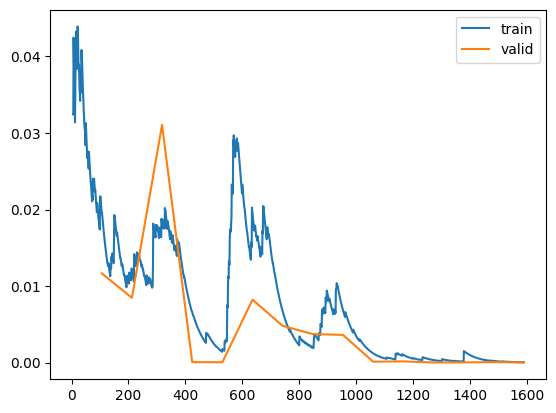

In [8]:
learn.recorder.plot_loss()

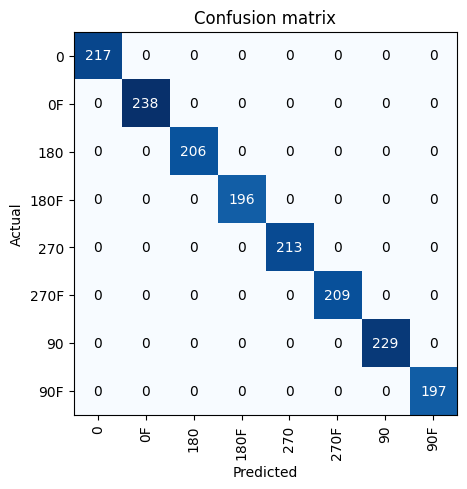

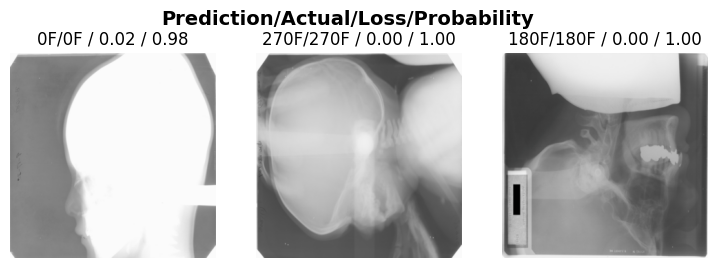

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(3)

Fine-tuning a relatively small model (Resnet18) for 15 epochs results in an accuracy of 100%.  
Next, we save the trained model for future use.

In [10]:
learn.path = Path("./")
learn.export("models/fliprot_resnet18_fp16_01")

### Insights and Observations
The metrics look good (both train-loss and validation-loss trended lower).  
Next, we should test the model against unseen data (the test set) to confirm that the model has generalized well and has not overfit.

---
### References
[1]: K. Swami, P. P. Deshpande, G. Khandelwal and A. Vijayvargiya, "Why my photos look sideways or upside down? Detecting canonical orientation of images using convolutional neural networks," 2017 IEEE International Conference on Multimedia & Expo Workshops (ICMEW), Hong Kong, China, 2017, pp. 495-500, doi: 10.1109/ICMEW.2017.8026216.